In [72]:
########################################################################
# 实际网络故障过程
########################################################################
def breakProcess(graph,theta,beta):
    # 获取点集 点的数量
    nodeList = list(graph.nodes)
    if(len(nodeList)!= n):
        graph.remove_node(nodeList[-1])
        nodeList.remove(nodeList[-1])
    nodeNum = len(list(graph.nodes))
    print(nodeNum,'nodeNum')
    # 负载矩阵以及容量矩阵
    load_matrix = np.zeros(len(nodeList))
    # 从边集合中取的点，依次断裂
    selectNumber = len(nodeList)
    selectNodeList = random.sample(nodeList, selectNumber)
    T = 0
    # 赋值负载矩阵以及容量矩阵
    for item in nodeList:
        load=networkChooseCopy.degree(item)**beta  #beta
        load_matrix[item]=load
    for iteml in selectNodeList:
        PointList = list(graph.neighbors(iteml))       
        if(iteml in PointList):
            PointList.remove(iteml)
        Tmax = 0
        Ttemp = load_matrix[iteml] 
        for litem in PointList:
            Ttemp = (load_matrix[iteml])/((graph.degree(iteml))*load_matrix[litem])
            if(Ttemp>Tmax):
                Tmax = Ttemp
                qushi = iteml
        if(T <Tmax):
            T = Tmax
    return T+1
########################################################################
# 连接策略
########################################################################
def graphBDS(graphInput,inDic,addNumber):
    graphOutput = copy.copy(graphInput)
    inDicSource = copy.copy(inDic)
    inDic = sorted(inDic.items(), key=lambda item:item[1],reverse=True)

    for i in range(n):
        if(addNumber<2):
            break
        if(inDicSource[inDic[i][0]]>0):
            for j in range(i+1,n):
                if(inDicSource[inDic[j][0]]>0):
                    if((graphOutput.has_edge(inDic[i][0],inDic[j][0])==0)&(inDicSource[inDic[i][0]]>0) &(inDicSource[inDic[j][0]]>0)  ):
                        graphOutput.add_edge(inDic[i][0],inDic[j][0])
                        addNumber = addNumber -2
                        inDicSource[inDic[i][0]] = inDicSource[inDic[i][0]] -1 
                        inDicSource[inDic[j][0]] = inDicSource[inDic[j][0]] -1 
                        if(addNumber<2):
                            break
    for i in range(n):
        while(inDicSource[inDic[i][0]]>1):
            randNode = random.randint(0,n-1)
            if(graphOutput.has_edge(inDic[i][0],randNode)==0):
                graphOutput.add_edge(inDic[i][0],randNode)
                inDicSource[inDic[i][0]] = inDicSource[inDic[i][0]]-2
                addNumber = addNumber - 2
    return graphOutput

def RLSgraph(graphSource,addEdge):
    graphRLS = graphSource.copy()
    nodeNum2 = len(list(graphSource.nodes))
    while(len(list(graphRLS.edges))<addEdge+len(list(graphSource.edges))):
        graphRLS.add_edge(int(random.random()*nodeNum2),int(random.random()*nodeNum2))
    return graphRLS

def HBSgraph(graphSource,addEdge):
    graphHBS = graphSource.copy()
    BC = network.betweenness_centrality(graphSource)
    nodeNum3 = len(list(graphSource.nodes))
    n = nodeNum3
    BCmartrix = np.zeros((n,n))
    
    for iBC in range(n):
        for jBC in range(n):
            if(iBC != jBC):
                BCmartrix[iBC][jBC] = BC[iBC]*BC[jBC]
    while(len(list(graphHBS.edges))<addEdge+len(list(graphSource.edges))):
        max_index = np.unravel_index(np.argmax(BCmartrix, axis=None), BCmartrix.shape)
        graphHBS.add_edge(max_index[0],max_index[1])
        BCmartrix[max_index[0]][max_index[1]] = 0
        BCmartrix[max_index[1]][max_index[0]] = 0
    
    return graphHBS


def LBSgraph(graphSource,addEdge):
    graphHBS = graphSource.copy()
    BC = network.betweenness_centrality(graphSource)
    nodeNum3 = len(list(graphSource.nodes))
    n = nodeNum3
    BCmartrix = np.zeros((n,n))
    
    for iBC in range(n):
        for jBC in range(n):
            if(iBC != jBC):
                BCmartrix[iBC][jBC] = BC[iBC]*BC[jBC]
    while(len(list(graphHBS.edges))<addEdge+len(list(graphSource.edges))):
        max_index = np.unravel_index(np.argmin(BCmartrix, axis=None), BCmartrix.shape)
        graphHBS.add_edge(max_index[0],max_index[1])
        BCmartrix[max_index[0]][max_index[1]] = 10000
        BCmartrix[max_index[1]][max_index[0]] = 10000
    
    return graphHBS
########################################################################
# 级联故障两种/三种策略的理论曲线
# 2020-11-23 20:00
# BDBDSBD
########################################################################
import sys
# sys.setrecursionlimit(40000)  # 如果递归出现爆栈问题，就用这句话
import networkx as network
import matplotlib.pyplot as plot
import math
import numpy as np
import random
import copy
from scipy.optimize import minimize
import numpy as np
from pyscipopt import Model
########################################################################
# 构造网络，节点数为n，度为，制作网络结构的浅拷贝
########################################################################
start = -0.5
end = 2
flagCircle = 0
gap = 31
Xlist =  np.linspace(start,end,gap)
Ymatrix = np.zeros((6,len(Xlist)))
ttTime = 1
for tt in range(ttTime):
    n = 100
    addEdge = int(n*0.4)
    beta = 1
    theta = 0
    networkName = 'WS'
    if(networkName == 'BA'):
        networkChoose = network.barabasi_albert_graph(n,4)
    if(networkName == 'WS'):        
        networkChoose = network.watts_strogatz_graph(n,8,0.1)
    if(networkName == 'ER'):  
        networkChoose = network.erdos_renyi_graph(n, 8/n)


for beta in Xlist:
########################################################################
# 数据预处理
########################################################################
    inittup = ()
    tup = ()
    tupK = ()
    tupM = ()
    for i in range(n):
        inittup = inittup + (0,)
        PointList = list(networkChoose.neighbors(i))
        if(PointList == []):
            networkChoose.add_edge(i,random.randint(0,n-1))
            PointList = list(networkChoose.neighbors(i))
        tup = tup + (networkChoose.degree(i),)
        tupK = tupK + (networkChoose.degree(i)**beta,)
        PointList = list(set(PointList))
        if(i in PointList):
            PointList.remove(i)
        minNeighborDegree = 1000
        maxNeighborDegree = 0
        for litem in PointList:
            if(minNeighborDegree>networkChoose.degree(litem)):
                minNeighborDegree=networkChoose.degree(litem)
            if(maxNeighborDegree<networkChoose.degree(litem)):
                maxNeighborDegree=networkChoose.degree(litem)
        if(beta >= 0):
            tupM = tupM + (minNeighborDegree**beta,)
        if(beta < 0):
            tupM = tupM + (maxNeighborDegree**beta,)
    alphaTheoryList = []
    for i in range(n):
        alphaTheoryList.append(tupK[i]/(tupM[i]*(tup[i])))
########################################################################
# 非线性整数规划求解过程
########################################################################
    Listadd = {}
    md = Model()
    names = locals()
    stringN = ''
    for i in range(n):
        names['x' + str(i) ] = md.addVar('x', lb=0, ub =addEdge, vtype='I')
        stringN = stringN + 'x'+str(i) + '+'
    # print(stringN[:-1])
    z = md.addVar('z')
    md.setObjective(z, sense='minimize')
    for i in range(n):
        md.addCons(tupK[i]/(tupM[i]*(tup[i]+ names['x' + str(i) ])) <= z)
    md.addCons(x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20+x21+x22+x23+x24+x25+x26+x27+x28+x29+x30+x31+x32+x33+x34+x35+x36+x37+x38+x39+x40+x41+x42+x43+x44+x45+x46+x47+x48+x49+x50+x51+x52+x53+x54+x55+x56+x57+x58+x59+x60+x61+x62+x63+x64+x65+x66+x67+x68+x69+x70+x71+x72+x73+x74+x75+x76+x77+x78+x79+x80+x81+x82+x83+x84+x85+x86+x87+x88+x89+x90+x91+x92+x93+x94+x95+x96+x97+x98+x99<=addEdge)    
    md.optimize()
    sol = md.getBestSol()
    for i in range(n):
        Listadd[i]=round(sol[names['x' + str(i) ]])

########################################################################
# 实验过程，计算级联故障alpha
########################################################################
    theta = 0
    flagCircle = flagCircle%(len(Xlist))
    networkChooseCopy = networkChoose.copy()
    flag = copy.copy(flagCircle)
    Ymatrix[0][flag]= breakProcess(networkChooseCopy,theta,beta)
    # Ymatrix[1][flag]= 1+sol[z]
    networkChooseCopy = networkChoose.copy()
    graphBD=graphBDS(networkChooseCopy,Listadd,addEdge)
    networkChooseCopy = networkChoose.copy()
    Ymatrix[2][flag]= breakProcess(graphBD,theta,beta)
    networkChooseCopy = networkChoose.copy()
    Ymatrix[3][flag] = breakProcess(LBSgraph(networkChooseCopy,int(addEdge/2)),theta,beta)
    networkChooseCopy = networkChoose.copy()
    Ymatrix[4][flag] = breakProcess(HBSgraph(networkChooseCopy,int(addEdge/2)),theta,beta)
    networkChooseCopy = networkChoose.copy()
    Ymatrix[5][flag] = breakProcess(RLSgraph(networkChooseCopy,int(addEdge/2)),theta,beta)

    flagCircle = flagCircle + 1

100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 nodeNum
100 

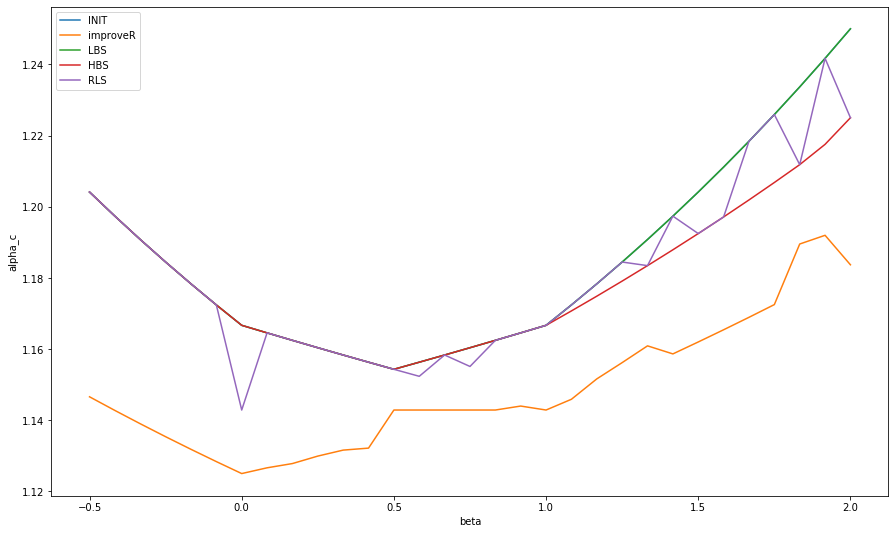

In [73]:
plot.figure(figsize=(15,9))
plot.xlabel("beta")
plot.ylabel("alpha_c")
plot.plot(Xlist[:],Ymatrix[0,:]/ttTime,label='INIT')
# plot.plot(Xlist[:],Ymatrix[1,:]/ttTime,label='improveT')
plot.plot(Xlist[:],Ymatrix[2,:]/ttTime,label='improveR')
plot.plot(Xlist[:],Ymatrix[3,:]/ttTime,label='LBS')
plot.plot(Xlist[:],Ymatrix[4,:]/ttTime,label='HBS')
plot.plot(Xlist[:],Ymatrix[5,:]/ttTime,label='RLS')
plot.legend()
plot.savefig(str(start)+','+str(end)+','+str(n)+','+str(addEdge)+str(networkName)+'.png')

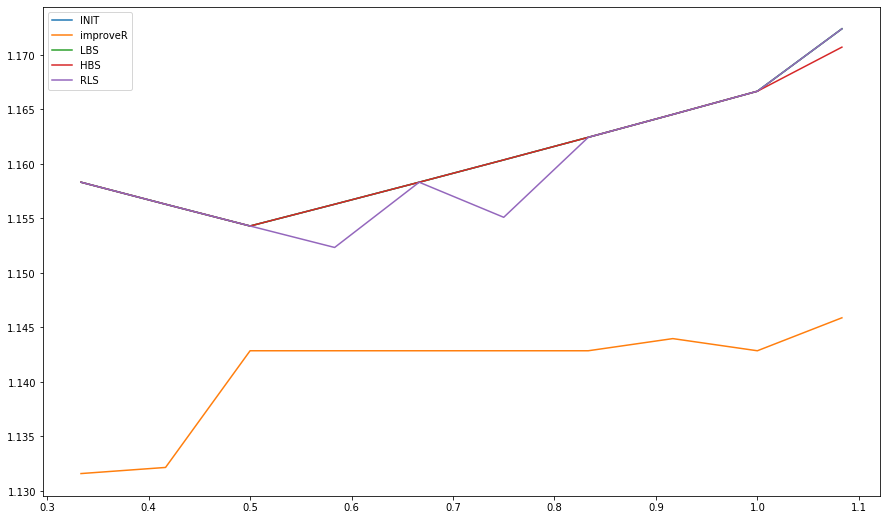

In [74]:
plot.figure(figsize=(15,9))
plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[0,int(gap/3):int(2*gap/3)]/ttTime,label='INIT')
# plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[1,int(gap/3):int(2*gap/3)]/ttTime,label='improveT')
plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[2,int(gap/3):int(2*gap/3)]/ttTime,label='improveR')
plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[3,int(gap/3):int(2*gap/3)]/ttTime,label='LBS')
plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[4,int(gap/3):int(2*gap/3)]/ttTime,label='HBS')
plot.plot(Xlist[int(gap/3):int(2*gap/3)],Ymatrix[5,int(gap/3):int(2*gap/3)]/ttTime,label='RLS')
plot.legend()
plot.savefig(str(start)+','+str(end)+','+str(n)+','+str(addEdge)+str(networkName)+'l'+'.png')

In [75]:
# import networkx as network

# networkChoose = network.watts_strogatz_graph(15,4,0.1)
# pos = network.circular_layout(networkChoose)
# network.draw(networkChoose,pos)